In [2]:
# install ultralytics if it hasn't been installed already
!pip install -q ultralytics

# import the necessary libraries
import ultralytics
from ultralytics import YOLO
import os
import re
import cv2
from spellchecker import SpellChecker
from IPython.display import Image, display
from IPython import display
import pandas as pd
from glob import glob
import shutil

# import helper functions
import helpers as show

# hide import output
display.clear_output()

# make sure the necessary dependencies have been installed
! yolo checks

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 29.1/201.2 GB disk)

OS                  Linux-6.1.58+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 83.48 GB
CPU                 Intel Xeon 2.20GHz
CUDA                12.1

matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.8.0.76>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.31.0>=2.23.0
scipy               ✅ 1.11.4>=1.4.1
torch               ✅ 2.2.1+cu121>=1.8.0
torchvision         ✅ 0.17.1+cu121>=0.9.0
tqdm                ✅ 4.66.2>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
thop                ✅ 0.1.1-2209072238>=0.1.1
pandas              ✅ 2.0.3>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0


In [3]:
# if using colab, set to true [no other implementation of code currently]
colab = True

if colab:
    # mount to google drive from colab
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    # import synthetic data
    with zipfile.ZipFile('/content/drive/MyDrive/synthetic_asl_letters.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
        zip_ref.close()

    # import mediapipe data
    with zipfile.ZipFile('/content/drive/MyDrive/synthetic_asl_letters_mp.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data')
        zip_ref.close()

    # define data.yaml locations for both models for easier use later
    raw_folder_path = '/content/data/synthetic_asl_letters/data.yaml'
    mp_folder_path = '/content/drive/MyDrive/synthetic_asl_letters_mp/data.yaml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Raw data, no mediapipe overlay

In [4]:
# use 'yolov9c.yaml' as argument to indicate training from scratch
raw_model = YOLO("yolov9c.yaml")  # build a new model from scratch

In [5]:
# train the model with the path to the data.yaml file as input, yaml is a configuration file so YOLOv9 knows how the data is formatted
results = raw_model.train(data=raw_folder_path, epochs=300)  # train the model
# display.clear_output() # uncomment if wanting to clear long output

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.yaml, data=/content/data/synthetic_asl_letters/data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 82.8MB/s]


Overriding model.yaml nc=80 with nc=26

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 341MB/s]


AMP: checks passed ✅


train: Scanning /content/data/synthetic_asl_letters/train/labels... 5460 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5460/5460 [00:04<00:00, 1364.25it/s]


train: New cache created: /content/data/synthetic_asl_letters/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/synthetic_asl_letters/valid/labels... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<00:00, 1179.82it/s]

val: New cache created: /content/data/synthetic_asl_letters/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.4G      3.112      5.685      4.251          7        640: 100%|██████████| 342/342 [01:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.73it/s]

                   all        520        520   0.000641    0.00549   0.000283   5.97e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      11.1G      2.919      5.327       3.87          9        640: 100%|██████████| 342/342 [01:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.01it/s]

                   all        520        520      0.404     0.0703     0.0268       0.01



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      11.5G      2.069      4.046      2.725          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.00it/s]

                   all        520        520      0.291      0.399      0.282      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.3G      1.463      2.971      2.058         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.08it/s]

                   all        520        520      0.584      0.661        0.7      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      11.5G      1.173      2.252      1.766          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]

                   all        520        520      0.792      0.791      0.896      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.4G      1.016      1.816      1.608          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520       0.87      0.875      0.947      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      11.2G     0.9196      1.538      1.512         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.922      0.875      0.956      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300        11G     0.8408      1.342      1.441          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.942      0.943      0.986       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      11.5G     0.7963      1.229      1.404          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.942      0.934      0.979       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300        11G     0.7638       1.13      1.374          6        640: 100%|██████████| 342/342 [01:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.955      0.987      0.994      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      11.2G     0.7283      1.042      1.329         13        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.975      0.976      0.994      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300        11G     0.6989     0.9675      1.308         12        640: 100%|██████████| 342/342 [01:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.977      0.988      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      11.5G     0.6745     0.8985      1.285          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.974      0.994      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      11.4G     0.6574     0.8528      1.277         15        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.981      0.991      0.994      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.2G     0.6525     0.8213      1.267         10        640: 100%|██████████| 342/342 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.988      0.994      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300        11G     0.6322     0.7922      1.251          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.983      0.987      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      11.5G     0.6266     0.7428      1.244          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.991      0.995      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      11.3G     0.6093     0.7234      1.225          4        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.988      0.995      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      11.5G     0.6047     0.6923      1.223          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.988      0.996      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      11.1G     0.5935      0.673      1.214          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.989      0.996      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      11.2G      0.584     0.6571      1.207         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.988      0.998      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300        11G     0.5824     0.6414      1.199          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.987      0.993      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      11.1G     0.5708     0.6109      1.194          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.986      0.992      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300        11G     0.5612     0.5959      1.188          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.992      0.998      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      11.5G     0.5572     0.5825       1.18          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.993      0.996      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300        11G     0.5515      0.566      1.178          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.992      0.997      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      11.1G     0.5484     0.5655      1.177          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.992          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300        11G     0.5474     0.5614      1.173          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.993      0.999      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      11.1G     0.5368     0.5433      1.164          4        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.994      0.999      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      11.3G     0.5294      0.525      1.154          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.995      0.998      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      11.5G     0.5356     0.5306      1.163         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.989          1      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300        11G     0.5292     0.5152      1.155          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.992      0.998      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      11.1G     0.5238     0.5097      1.153          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.995          1      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300        11G     0.5194     0.5046      1.149          7        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.991      0.998      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      11.2G     0.5112     0.4858      1.144          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.995          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300        11G     0.5088      0.474      1.135          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.991      0.993      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      11.2G     0.5097     0.4777      1.134         10        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.995          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300        11G     0.5044     0.4748      1.135         10        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.993          1      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      11.2G     0.5012     0.4587      1.132          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995      0.999      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300        11G     0.4933     0.4497      1.127         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.996      0.999      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      11.2G     0.4904     0.4591      1.123          5        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.995      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.1G     0.4879     0.4447      1.116          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520       0.99      0.999      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      11.5G     0.4947     0.4473      1.126          5        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.996      0.999      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.3G     0.4846     0.4428      1.119         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995          1      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      11.5G     0.4826     0.4263      1.115          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.994      0.999      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300        11G     0.4864     0.4332      1.125          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.993          1      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      11.2G     0.4824     0.4223      1.113         15        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.994      0.998      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300        11G     0.4757      0.411      1.109          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.995          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.2G     0.4689     0.4119      1.109          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300        11G     0.4673     0.4023      1.106         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.994          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      11.5G     0.4689     0.4054      1.108          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.994          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      11.4G      0.468      0.404      1.106          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995      0.998      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      11.2G     0.4664     0.3971        1.1          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.994          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        11G     0.4652       0.39      1.104          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.992          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      11.2G     0.4635     0.3921      1.104          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300        11G     0.4553     0.3852      1.101         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.991          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      11.2G     0.4614     0.3899      1.099          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.995          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300        11G      0.453     0.3765       1.09          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995      0.999      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      11.1G      0.453     0.3789      1.094          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300        11G     0.4473     0.3733      1.084          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.995          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      11.1G     0.4513     0.3671      1.093         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.995          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300        11G     0.4491     0.3646      1.087          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      11.2G     0.4476     0.3646      1.086          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.995          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.3G     0.4433     0.3633      1.085         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      11.1G      0.444     0.3641      1.084          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300        11G     0.4428      0.363      1.083         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.994      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      11.1G     0.4432     0.3607      1.087         13        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.994          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300        11G     0.4356     0.3575      1.078         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      11.5G     0.4391     0.3535      1.082          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300        11G     0.4317     0.3444      1.078          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.994          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      11.5G      0.437      0.347      1.078         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.995      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300        11G     0.4299     0.3422      1.075          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.994      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      11.2G     0.4313     0.3477      1.073         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.994          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300        11G     0.4307     0.3424      1.072         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.2G      0.419     0.3297       1.06         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300        11G     0.4244     0.3423      1.066          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.2G     0.4204     0.3335      1.064         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300        11G     0.4226     0.3332      1.067          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      11.1G     0.4178     0.3307      1.067          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300        11G       0.42     0.3267      1.068          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.995          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      11.1G       0.42     0.3315      1.064         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300        11G     0.4266     0.3356      1.071         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      11.1G     0.4174     0.3264      1.064          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300        11G     0.4141     0.3238      1.065          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.2G     0.4074     0.3193      1.056         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300        11G     0.4123     0.3201      1.057          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

                   all        520        520      0.993      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      11.1G     0.4114     0.3134      1.054         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300        11G     0.4043     0.3127      1.049          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      11.1G     0.4041     0.3125      1.056          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300        11G      0.407      0.317      1.055          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      11.2G     0.4051     0.3089      1.051          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.995      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300        11G     0.4041     0.3137      1.056          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995      0.996      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.5G      0.401     0.3125      1.051          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996      0.999      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.3G     0.3981     0.3041      1.045         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.995      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      11.2G      0.404     0.3073      1.055         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300        11G     0.3969     0.3018      1.044          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      11.5G     0.4004     0.3067      1.048          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.995      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      11.4G     0.3978     0.3043      1.043          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.5G     0.3936      0.307      1.043          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.4G     0.3937     0.2982      1.042          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      11.2G     0.3915     0.2963      1.041          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        11G     0.3931     0.2945      1.038          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      11.5G     0.3911     0.2958      1.037          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.3G     0.3936     0.2967      1.042          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.996      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.5G     0.3849     0.2893      1.033          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      11.3G     0.3846     0.2897      1.035          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      11.2G     0.3913     0.2935      1.037          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.3G     0.3871     0.2966      1.035          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.996      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.1G     0.3854     0.2901      1.036          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.995      0.998      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300        11G     0.3831     0.2923      1.032          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.996      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      11.1G     0.3796     0.2777      1.029          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.997      0.997      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300        11G     0.3755     0.2815      1.024          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.996      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      11.5G     0.3685     0.2769      1.024          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.997      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.4G     0.3759      0.284      1.029         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997      0.997      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      11.5G     0.3774     0.2839      1.028          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

                   all        520        520      0.997      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300        11G     0.3733     0.2816      1.025          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.996      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      11.5G     0.3738     0.2812      1.029          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.996      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300        11G     0.3712     0.2798      1.021         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      11.1G     0.3732      0.279      1.025          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      11.1G     0.3738     0.2744      1.028          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.996      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      11.5G     0.3694     0.2761       1.02          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300        11G     0.3669     0.2745      1.018          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      11.2G     0.3644      0.272      1.018          8        640: 100%|██████████| 342/342 [01:10<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.997      0.998      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300        11G     0.3636     0.2717      1.013         12        640: 100%|██████████| 342/342 [01:10<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997      0.997      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      11.5G     0.3629     0.2678      1.017         11        640: 100%|██████████| 342/342 [01:10<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.997      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300        11G     0.3609      0.267      1.019         16        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.996      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      11.1G     0.3559     0.2652      1.009          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      11.1G     0.3569     0.2665       1.01          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.997      0.997      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      11.2G     0.3557     0.2622      1.009          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300        11G     0.3646     0.2691      1.015          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      11.5G     0.3527     0.2619      1.009          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300        11G     0.3549     0.2597      1.011          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      11.2G      0.351     0.2552      1.009          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300        11G     0.3566     0.2607      1.011          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      11.5G     0.3513     0.2594      1.003         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.997      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300        11G     0.3514     0.2587      1.009         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.1G     0.3484     0.2625      1.007          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.997      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300        11G     0.3472     0.2557     0.9988          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      11.5G     0.3464      0.261      1.001         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.997      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      11.4G     0.3474     0.2587      1.004          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      11.4G     0.3406     0.2551     0.9977          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300        11G     0.3426      0.256      1.003          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.997      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      11.1G     0.3427     0.2514     0.9998         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.998      0.997      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300        11G      0.338     0.2449     0.9962          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997      0.997      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      11.2G     0.3407     0.2484     0.9985          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.997      0.997      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.4G     0.3382     0.2488     0.9946          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      11.5G     0.3369     0.2482     0.9944         13        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.998      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        11G     0.3388      0.251     0.9968         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.998      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      11.5G     0.3375     0.2505      0.995          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.998      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.4G      0.331     0.2421       0.99         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997      0.999      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      11.5G     0.3373     0.2479     0.9941          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.997      0.998      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      11.4G     0.3335     0.2483     0.9942          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997      0.998      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      11.1G     0.3295     0.2407     0.9899          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997      0.998      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300        11G     0.3326     0.2433      0.993          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.997      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      11.5G      0.333     0.2486     0.9903         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      11.3G      0.326     0.2403     0.9806         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      11.2G      0.323     0.2429     0.9836          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300        11G     0.3279     0.2424     0.9835          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.1G     0.3243     0.2349     0.9843         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300        11G     0.3237     0.2342     0.9861         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      11.1G     0.3212     0.2327     0.9813          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300        11G      0.317     0.2301     0.9772          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      11.2G     0.3224     0.2346     0.9829          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      11.1G     0.3211     0.2365     0.9781          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      11.2G     0.3148     0.2299     0.9755          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300        11G     0.3158     0.2347     0.9779          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      11.5G     0.3118      0.232     0.9739          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300        11G     0.3113     0.2317      0.972         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.5G     0.3089     0.2284     0.9714         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300        11G     0.3115     0.2264     0.9735          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      11.5G     0.3093      0.225     0.9725          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300        11G     0.3159     0.2326     0.9777         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.997          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      11.1G     0.3074     0.2244     0.9716          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300        11G     0.3103     0.2307     0.9734          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      11.2G     0.3033     0.2232     0.9662          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300        11G     0.3095     0.2263     0.9733          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.1G     0.3019     0.2195     0.9645          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300        11G     0.3029     0.2266     0.9673          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      11.5G     0.3012     0.2238     0.9662          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300        11G     0.3036      0.223     0.9669          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      11.1G        0.3     0.2187     0.9638          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300        11G     0.2959     0.2163     0.9588         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      11.5G     0.2973     0.2173     0.9624          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      11.3G     0.2968      0.215     0.9606          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      11.5G     0.2924     0.2122     0.9542         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300        11G     0.2948     0.2144     0.9606         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

                   all        520        520      0.997          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      11.1G     0.2936     0.2124     0.9617          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300        11G     0.2941      0.213     0.9596          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.998          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      11.1G     0.2911       0.21     0.9571          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.4G     0.2899     0.2082     0.9592          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      11.2G     0.2905     0.2118     0.9535          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      11.4G     0.2919     0.2185     0.9572          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.998          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      11.5G     0.2876     0.2102     0.9595          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.998          1      0.995      0.955
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 93, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



193 epochs completed in 3.954 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9c summary (fused): 384 layers, 25339294 parameters, 0 gradients, 102.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.69it/s]


                   all        520        520      0.996      0.999      0.995      0.963
                     A        520         23      0.995          1      0.995      0.965
                     B        520         19      0.996          1      0.995      0.969
                     C        520         23      0.996          1      0.995      0.935
                     D        520         23      0.995          1      0.995      0.918
                     E        520         15          1          1      0.995      0.955
                     F        520         16      0.993          1      0.995      0.992
                     G        520         19      0.994          1      0.995      0.967
                     H        520         22      0.997          1      0.995       0.94
                     I        520         20      0.994          1      0.995      0.992
                     J        520         26      0.995          1      0.995      0.978
                     

In [6]:
results = raw_model.val(save_json=True)  # evaluate model performance on the validation set

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9c summary (fused): 384 layers, 25339294 parameters, 0 gradients, 102.4 GFLOPs


val: Scanning /content/data/synthetic_asl_letters/valid/labels.cache... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.18it/s]


                   all        520        520      0.996      0.999      0.995      0.963
                     A        520         23      0.995          1      0.995       0.96
                     B        520         19      0.996          1      0.995      0.969
                     C        520         23      0.996          1      0.995      0.935
                     D        520         23      0.995          1      0.995      0.919
                     E        520         15          1          1      0.995      0.955
                     F        520         16      0.993          1      0.995      0.992
                     G        520         19      0.994          1      0.995      0.967
                     H        520         22      0.997          1      0.995       0.94
                     I        520         20      0.994          1      0.995      0.992
                     J        520         26      0.995          1      0.995      0.979
                     

In [ ]:
# calculate f1 score per epoch
def calculate_f1(row):
    # the results csv has weird spacing, so the naming conventions for each column must be as follows:
    precision = row['   metrics/precision(B)']
    recall = row['      metrics/recall(B)']
    # check to avoid division by zero
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0

# read in the base YOLOv9 model results.csv as a dataframe
file_path = '/content/runs/detect/train/results.csv'
raw_df = pd.read_csv(file_path)

# apply the function row-wise and create a new column for F1 score
raw_df['F1_score'] = raw_df.apply(calculate_f1, axis=1)

raw_df.to_csv('raw_results.csv', index=True)

# hard code download to make training and running this notebook overnight a little easier
from google.colab import files
files.download("/content/raw_results.csv")

Data with mediapipe overlay

In [8]:
# follow same steps as before
mp_model = YOLO("yolov9c.yaml")

In [9]:
results = mp_model.train(data=mp_folder_path, epochs=300)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.yaml, data=/content/drive/MyDrive/synthetic_asl_letters_mp.zip, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

Unzipping /content/drive/MyDrive/synthetic_asl_letters_mp.zip to /content/datasets/synthetic_asl_letters_mp...: 100%|██████████| 12493/12493 [00:04<00:00, 2610.72file/s]

Overriding model.yaml nc=80 with nc=26

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    


  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  8                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPELAN         [512, 512, 256]               
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1   3119616  ultralytics.nn.modules.block.RepNCSPELAN4    [1024, 512, 512, 256, 1]      
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/datasets/synthetic_asl_letters_mp/train/labels... 5460 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5460/5460 [00:04<00:00, 1325.22it/s]


train: New cache created: /content/datasets/synthetic_asl_letters_mp/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/synthetic_asl_letters_mp/valid/labels... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<00:00, 955.55it/s]

val: New cache created: /content/datasets/synthetic_asl_letters_mp/valid/labels.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      11.6G      3.092      5.712      4.393          7        640: 100%|██████████| 342/342 [01:17<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


                   all        520        520    0.00468     0.0302    0.00354   0.000831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300        12G        2.8       5.04       3.76          9        640: 100%|██████████| 342/342 [01:12<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  4.72it/s]


                   all        520        520      0.232      0.178     0.0633     0.0241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300        12G      1.835      3.709      2.523          5        640: 100%|██████████| 342/342 [01:10<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

                   all        520        520      0.399       0.56      0.474      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      11.6G      1.341      2.754      1.952         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.09it/s]

                   all        520        520      0.499      0.717      0.699      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300        12G        1.1      2.124      1.688          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.17it/s]

                   all        520        520      0.696      0.679      0.795      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      11.9G     0.9759      1.776       1.56          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]

                   all        520        520      0.796      0.831      0.906      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300        12G      0.899      1.542      1.483         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.905      0.913      0.962      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      11.9G     0.8263      1.362      1.421          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.19it/s]

                   all        520        520      0.927       0.95      0.986      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300        12G     0.7874      1.253      1.388          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.954      0.944      0.985       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      11.9G      0.754      1.158      1.363          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.973      0.964      0.991      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300        12G     0.7217      1.075      1.323         13        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520       0.96      0.974      0.989      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300        12G     0.6976     0.9937      1.307         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.982      0.989      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300        12G     0.6756     0.9327      1.285          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.978      0.976      0.992      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300        12G     0.6577     0.8847      1.275         15        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]

                   all        520        520      0.967      0.981      0.993      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      11.7G     0.6524     0.8506      1.264         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.981       0.99      0.993      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      11.6G      0.638     0.8195      1.255          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520       0.98      0.989      0.995      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300        12G     0.6313     0.7758      1.248          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.984      0.988      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300        12G     0.6112     0.7643      1.228          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.991      0.996      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300        12G     0.6116      0.728      1.229          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.988      0.992      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300        12G     0.5958     0.7086      1.215          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.984      0.993      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300        12G     0.5891     0.7005      1.211         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.979      0.986      0.994      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      11.9G     0.5857     0.6758      1.202          9        640: 100%|██████████| 342/342 [01:10<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520       0.99      0.993      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300        12G     0.5767      0.649      1.199          9        640: 100%|██████████| 342/342 [01:10<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.986      0.996      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      11.6G     0.5653     0.6245      1.189          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.982      0.991      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300        12G     0.5634     0.6171      1.186          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.991      0.996      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      11.9G     0.5628     0.6036      1.186          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.994      0.994      0.995      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300        12G      0.554     0.6072      1.182          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.988      0.995      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300        12G     0.5571     0.5973      1.178          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.993      0.995      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300        12G     0.5422     0.5752      1.168          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.993      0.998      0.995      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300        12G     0.5385     0.5518      1.161          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.991      0.999      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300        12G     0.5396     0.5513      1.163         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

                   all        520        520      0.993      0.998      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      11.9G     0.5366     0.5489      1.163          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.989      0.996      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300        12G     0.5282     0.5264      1.157          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.991      0.997      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300        12G     0.5194     0.5232      1.149          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.993      0.999      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300        12G     0.5227     0.5156      1.152          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.993      0.996      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300        12G     0.5192     0.5091      1.145          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.994      0.999      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300        12G     0.5211     0.5044      1.146         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.993      0.997      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      11.9G      0.515     0.4988      1.144         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994      0.996      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300        12G     0.5127     0.4833       1.14          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.992      0.998      0.995      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300        12G     0.5053     0.4722      1.138         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.21it/s]

                   all        520        520      0.994      0.999      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300        12G     0.5007     0.4714      1.131          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.992      0.998      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      11.9G     0.4999       0.47      1.126          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.20it/s]

                   all        520        520       0.99          1      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300        12G     0.5005      0.462      1.132          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.991      0.999      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      11.9G     0.4989     0.4662      1.132         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.992      0.997      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300        12G     0.4927     0.4393      1.123          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.993      0.999      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      11.9G     0.4963     0.4512      1.135          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.994      0.997      0.995      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300        12G     0.4943     0.4496      1.125         15        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.995      0.998      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      11.9G     0.4862     0.4338      1.118          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.995      0.995      0.994      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      11.9G     0.4844     0.4397      1.121          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.992          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      11.9G     0.4798     0.4229      1.115         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995          1      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300        12G     0.4827     0.4264      1.119          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.994          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300        12G     0.4774     0.4168      1.113          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.995          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300        12G     0.4786     0.4152      1.107          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994      0.996      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300        12G     0.4729     0.4091      1.109          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.993          1      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300        12G     0.4729      0.405      1.107          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      11.6G     0.4677     0.4032      1.109         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300        12G     0.4721     0.4044      1.109          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.995          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300        12G     0.4622     0.3976      1.103          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300        12G     0.4633      0.393      1.106          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.995      0.999      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300        12G     0.4627     0.3871      1.099          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300        12G     0.4596      0.381      1.105         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.995          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300        12G     0.4577     0.3836      1.098          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.996          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300        12G     0.4568     0.3741      1.091          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.994          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      11.6G     0.4543     0.3702      1.095         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300        12G     0.4561     0.3725      1.095          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996          1      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      11.9G     0.4519     0.3771       1.09         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      11.7G     0.4508     0.3702      1.092         13        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.994      0.999      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      11.9G     0.4458     0.3647      1.086         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300        12G      0.452     0.3758      1.094          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      11.6G     0.4423      0.361      1.086          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300        12G     0.4476     0.3564      1.089         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.22it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      11.9G     0.4416     0.3596      1.086          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300        12G     0.4437     0.3633      1.083         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.994          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      11.9G     0.4432     0.3572      1.083         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      11.7G     0.4364     0.3528      1.075         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      11.7G     0.4357     0.3468      1.079          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      11.7G     0.4303      0.343      1.073         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      11.6G     0.4354     0.3445      1.077          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300        12G     0.4338     0.3435      1.081          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996          1      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      11.9G     0.4317     0.3395       1.08          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300        12G     0.4309     0.3406      1.074         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300        12G      0.439     0.3421      1.081         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.995          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300        12G     0.4309     0.3413      1.073          6        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      11.9G     0.4217     0.3329      1.074          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      11.7G     0.4194     0.3264      1.069         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.995          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      11.7G     0.4237     0.3314      1.067          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.996      0.998      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300        12G     0.4199     0.3258      1.066         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300        12G     0.4221     0.3262      1.066          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300        12G     0.4152     0.3212      1.068          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.996          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      11.9G     0.4177     0.3202      1.065          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]

                   all        520        520      0.995          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300        12G     0.4177     0.3178      1.062          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.995      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      11.9G     0.4126     0.3141      1.062          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.993      0.996      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      11.7G     0.4142     0.3201      1.063          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.993          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      11.9G      0.409     0.3121      1.056         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.995          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300        12G     0.4152     0.3193      1.064         11        640: 100%|██████████| 342/342 [01:10<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      11.7G     0.4093     0.3168      1.057          5        640: 100%|██████████| 342/342 [01:10<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300        12G     0.4126     0.3153      1.058          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.996          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300        12G     0.4032     0.3022      1.051          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.995          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      11.7G     0.4063     0.3184      1.054          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      11.6G     0.4035     0.3069      1.052          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.996      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300        12G     0.4023     0.3045      1.052          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.995          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300        12G     0.4004     0.3009      1.043          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.996      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300        12G     0.4027     0.3003      1.048          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.995      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      11.5G     0.4001     0.3065       1.05          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.995      0.995      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      11.7G     0.3943     0.2919      1.042          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.995      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300        12G     0.3928      0.299      1.044          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.996      0.998      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300        12G     0.3986     0.3009      1.046          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      11.6G     0.4015     0.3003      1.049          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      11.7G     0.3969     0.2971      1.049          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.995      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      11.6G     0.3932     0.3014      1.042          7        640: 100%|██████████| 342/342 [01:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.28it/s]

                   all        520        520      0.996      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300        12G     0.3909     0.2945       1.04          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.996          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300        12G     0.3899     0.2896      1.038          4        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.995      0.998      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300        12G     0.3809     0.2854      1.034          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.995      0.998      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      11.9G     0.3877     0.2912      1.038         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.995      0.998      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300        12G     0.3867     0.2924      1.037          7        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.996      0.998      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300        12G     0.3828     0.2849      1.033          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300        12G     0.3821     0.2892      1.037          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.997      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300        12G     0.3797     0.2829      1.028         10        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996      0.997      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300        12G     0.3819     0.2867      1.031          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.29it/s]

                   all        520        520      0.997      0.997      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300        12G      0.382     0.2852      1.034          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.997      0.997      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300        12G     0.3777     0.2822      1.027          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.27it/s]

                   all        520        520      0.996      0.997      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      11.9G      0.379     0.2786      1.029          9        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.33it/s]

                   all        520        520      0.996      0.997      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300        12G     0.3761     0.2776      1.026          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.997      0.998      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300        12G     0.3721     0.2789      1.025         12        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.998      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300        12G     0.3737     0.2723      1.025         11        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.996      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300        12G     0.3742     0.2775      1.032         16        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.998      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300        12G     0.3685     0.2704      1.021          5        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.996      0.999      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300        12G     0.3659      0.271      1.019          3        640: 100%|██████████| 342/342 [01:09<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.996          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300        12G     0.3643     0.2733      1.013          8        640: 100%|██████████| 342/342 [01:09<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.994          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      11.6G     0.3724     0.2794      1.021          5        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.997      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300        12G     0.3615     0.2665      1.019          5        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      11.9G     0.3671     0.2695      1.021          7        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

                   all        520        520      0.997          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300        12G     0.3638     0.2672       1.02          6        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300        12G      0.366     0.2673       1.02          7        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300        12G      0.362     0.2663      1.013         10        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]

                   all        520        520      0.997      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300        12G     0.3612      0.269      1.018         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

                   all        520        520      0.997      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      11.7G     0.3614     0.2692      1.018          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      11.9G     0.3617     0.2612      1.011          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300        12G     0.3573     0.2655      1.012         11        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      11.7G       0.36     0.2624      1.013          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300        12G     0.3559     0.2626      1.009          6        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      11.9G     0.3566     0.2594      1.015          7        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.44it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      11.7G     0.3491     0.2558      1.007         12        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      11.9G      0.349     0.2536      1.005          4        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300        12G     0.3504      0.253      1.008          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      11.6G     0.3527     0.2577      1.006          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.996          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300        12G     0.3469      0.253      1.005         13        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300        12G       0.35     0.2578      1.002         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300        12G      0.349     0.2552      1.005          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      11.9G     0.3468     0.2469      1.005         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300        12G     0.3445     0.2541     0.9997          6        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300        12G     0.3447     0.2491      1.003          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.998          1      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300        12G     0.3396     0.2425          1          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      11.6G     0.3434     0.2528      1.002          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300        12G      0.341     0.2506     0.9995         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300        12G     0.3346     0.2466     0.9877         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300        12G     0.3371     0.2462     0.9933          6        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      11.9G      0.335     0.2439     0.9891          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      11.9G     0.3359     0.2422     0.9917         11        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      11.9G     0.3355     0.2438     0.9938         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300        12G     0.3327     0.2384     0.9916          7        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300        12G     0.3292     0.2364     0.9849          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300        12G     0.3358     0.2415     0.9955          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300        12G     0.3266     0.2433     0.9866          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300        12G     0.3258     0.2326     0.9859          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      11.9G      0.327     0.2355     0.9873          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300        12G     0.3249     0.2355     0.9819          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.997          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      11.6G     0.3202      0.234     0.9782         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      11.9G      0.324     0.2359     0.9834         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300        12G     0.3237     0.2311     0.9833          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300        12G     0.3221     0.2299      0.984          5        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.997      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      11.9G      0.324     0.2329     0.9861         11        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300        12G     0.3198     0.2252     0.9799          5        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.40it/s]

                   all        520        520      0.997          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      11.9G     0.3201     0.2338     0.9831          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.998      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      11.7G     0.3214     0.2325      0.977          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.998      0.999      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      11.6G     0.3196     0.2366     0.9807          5        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.998      0.999      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      11.6G     0.3154     0.2314     0.9757          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]

                   all        520        520      0.998      0.999      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      11.6G     0.3201      0.235     0.9809          5        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300        12G     0.3143     0.2285     0.9756          4        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300        12G     0.3153     0.2274     0.9776          8        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.42it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300        12G     0.3084     0.2246     0.9696          5        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.34it/s]

                   all        520        520      0.998          1      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      11.6G     0.3095     0.2235     0.9713         11        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300        12G     0.3088     0.2254     0.9723          7        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.43it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300        12G     0.3106     0.2255     0.9703          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300        12G     0.3058     0.2222     0.9641         12        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.37it/s]

                   all        520        520      0.998          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300        12G     0.3086     0.2186     0.9724         10        640: 100%|██████████| 342/342 [01:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.36it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300        12G     0.3049     0.2198     0.9716          6        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300        12G     0.3028     0.2188     0.9665          8        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.41it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300        12G     0.3026     0.2193     0.9667          7        640: 100%|██████████| 342/342 [01:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.38it/s]

                   all        520        520      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      11.9G     0.3006     0.2134      0.969          5        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.35it/s]

                   all        520        520      0.998          1      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300        12G     0.3035     0.2165     0.9656          9        640: 100%|██████████| 342/342 [01:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.39it/s]

                   all        520        520      0.998          1      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300        12G     0.3052     0.2185     0.9683          9        640: 100%|██████████| 342/342 [01:08<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:03<00:00,  5.32it/s]

                   all        520        520      0.998          1      0.995      0.956
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 92, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



192 epochs completed in 3.930 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 51.7MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 51.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9c summary (fused): 384 layers, 25339294 parameters, 0 gradients, 102.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:04<00:00,  3.80it/s]


                   all        520        520      0.993      0.996      0.995      0.963
                     A        520         23      0.995          1      0.995      0.962
                     B        520         19      0.994          1      0.995      0.967
                     C        520         23          1          1      0.995      0.963
                     D        520         23      0.996          1      0.995      0.927
                     E        520         15      0.991          1      0.995      0.954
                     F        520         16          1          1      0.995      0.992
                     G        520         19      0.966          1      0.995       0.98
                     H        520         22      0.995          1      0.995      0.959
                     I        520         20      0.993          1      0.995      0.995
                     J        520         26      0.995          1      0.995      0.975
                     

In [10]:
results = mp_model.val(save_json=True)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9c summary (fused): 384 layers, 25339294 parameters, 0 gradients, 102.4 GFLOPs


val: Scanning /content/datasets/synthetic_asl_letters_mp/valid/labels.cache... 520 images, 0 backgrounds, 0 corrupt: 100%|██████████| 520/520 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.61it/s]


                   all        520        520      0.993      0.996      0.995      0.962
                     A        520         23      0.995          1      0.995      0.961
                     B        520         19      0.994          1      0.995      0.967
                     C        520         23          1          1      0.995      0.963
                     D        520         23      0.996          1      0.995      0.927
                     E        520         15      0.991          1      0.995      0.947
                     F        520         16          1          1      0.995      0.992
                     G        520         19      0.966          1      0.995       0.98
                     H        520         22      0.995          1      0.995      0.958
                     I        520         20      0.993          1      0.995      0.991
                     J        520         26      0.995          1      0.995      0.975
                     

In [11]:
file_path = '/content/runs/detect/train3/results.csv'
mp_df = pd.read_csv(file_path)

# apply the function row-wise and create a new column for F1 score
mp_df['F1_score'] = mp_df.apply(calculate_f1, axis=1)

mp_df.to_csv('mp_results.csv', index=True)

files.download("/content/mp_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Displaying the results of the two models

In [17]:
results_path = '/content/runs/detect/train'

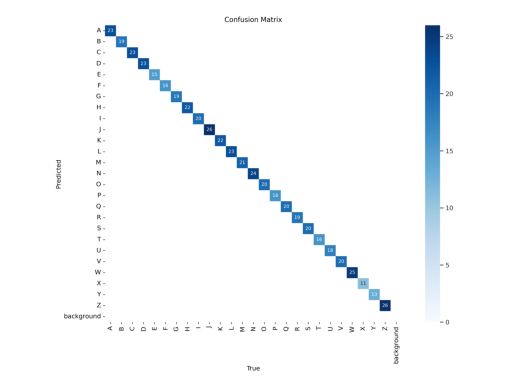

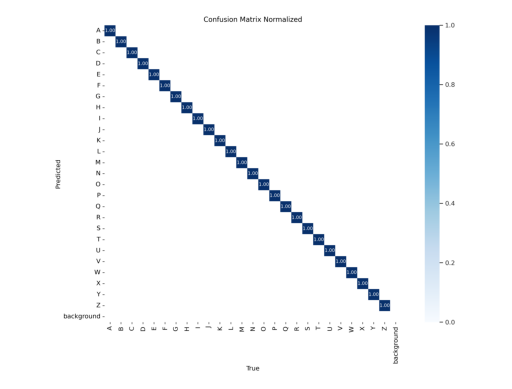

In [18]:
show.conf_matrices(results_path)

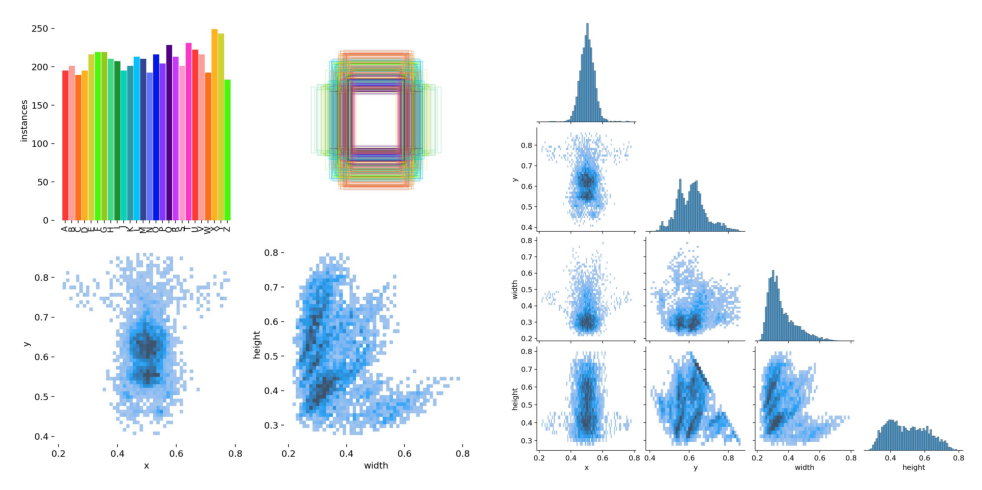

In [19]:
show.labels(results_path)

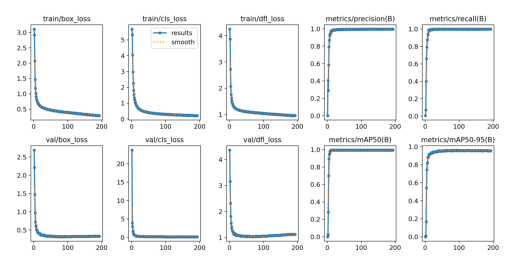

In [20]:
show.results(results_path)

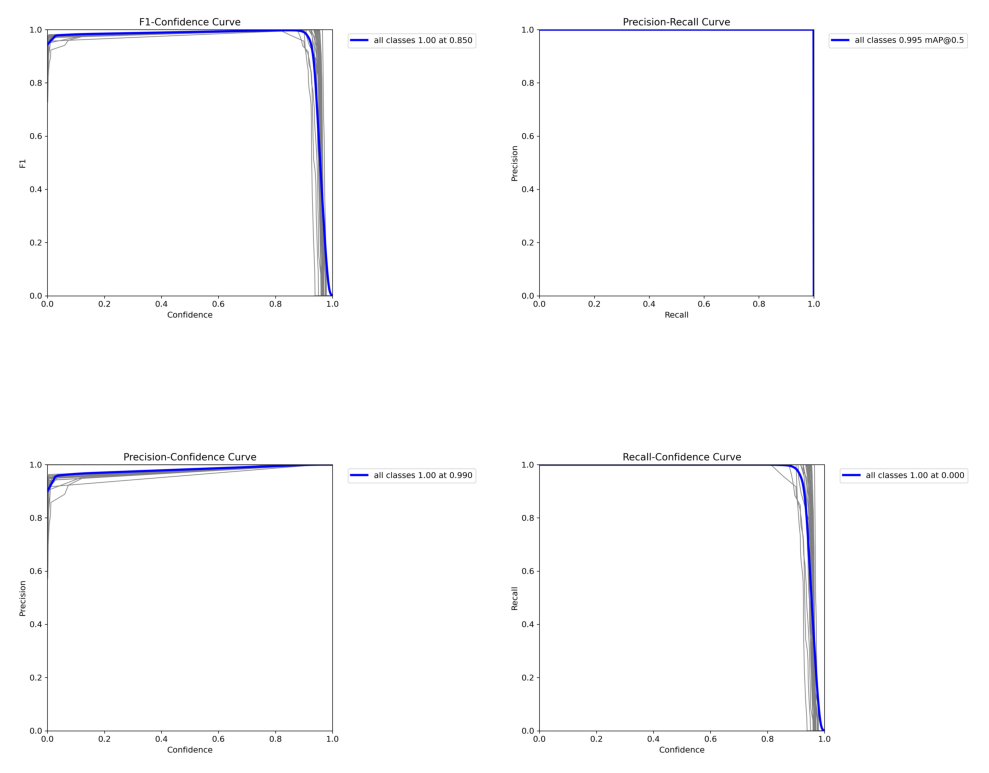

In [21]:
show.curves(results_path)

In [22]:
df = show.df(results_path)
df.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.1120,5.6848,4.2512,0.00064,0.00549,0.00028,0.00006,2.68730,23.7130,4.3598,0.003324,0.003324,0.003324
1,2,2.9188,5.3273,3.8702,0.40411,0.07033,0.02676,0.01003,2.20770,3.8403,3.1567,0.006635,0.006635,0.006635
2,3,2.0685,4.0457,2.7246,0.29104,0.39874,0.28201,0.16810,1.47030,2.8628,2.3220,0.009924,0.009924,0.009924
3,4,1.4627,2.9712,2.0580,0.58448,0.66134,0.70040,0.54258,0.97323,1.6453,1.8264,0.009901,0.009901,0.009901
4,5,1.1727,2.2515,1.7663,0.79169,0.79102,0.89551,0.74324,0.72257,1.1092,1.5509,0.009868,0.009868,0.009868


In [24]:
results_path = '/content/runs/detect/train3'

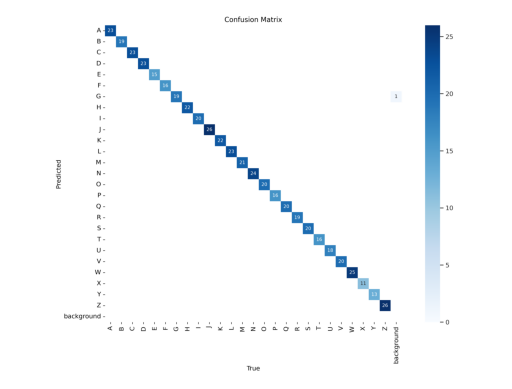

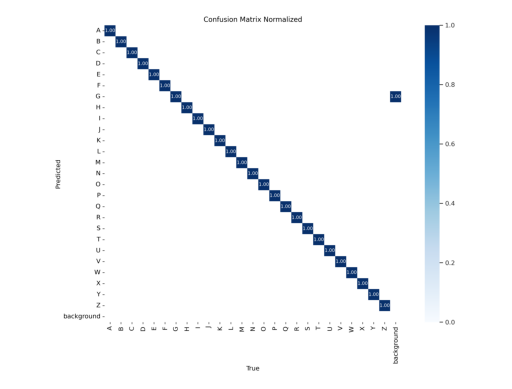

In [25]:
show.conf_matrices(results_path)

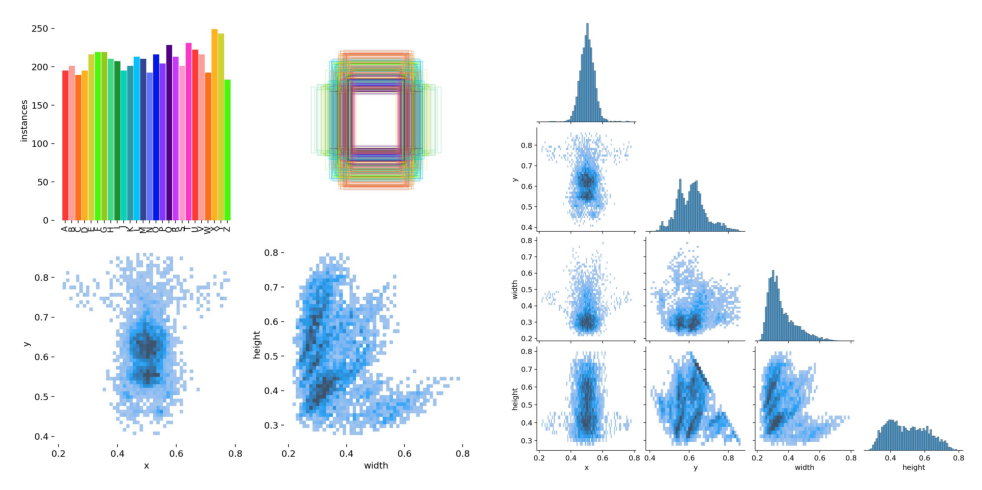

In [26]:
show.labels(results_path)

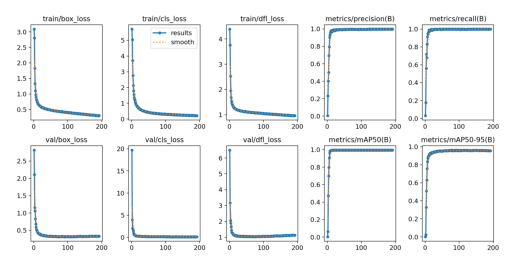

In [27]:
show.results(results_path)

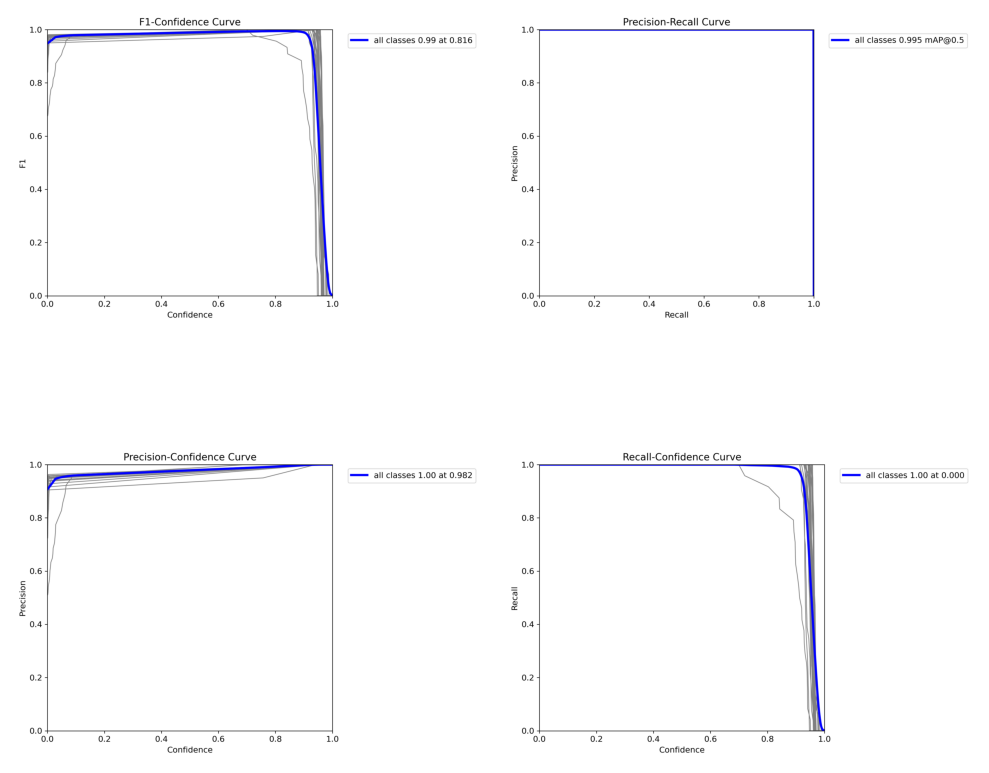

In [28]:
show.curves(results_path)

In [29]:
df = show.df(results_path)
df.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,3.0923,5.7115,4.3927,0.00468,0.03021,0.00354,0.00083,2.81410,19.7010,6.4976,0.003324,0.003324,0.003324
1,2,2.8001,5.0404,3.7603,0.23201,0.17769,0.06328,0.02414,2.11080,3.9492,3.1602,0.006635,0.006635,0.006635
2,3,1.8346,3.7086,2.5228,0.39931,0.56019,0.47389,0.32643,1.15550,2.0284,2.0481,0.009924,0.009924,0.009924
3,4,1.3410,2.7540,1.9519,0.49904,0.71707,0.69916,0.50920,1.06060,1.8471,1.8926,0.009901,0.009901,0.009901
4,5,1.0998,2.1244,1.6884,0.69566,0.67913,0.79514,0.62827,0.82851,1.4390,1.6721,0.009868,0.009868,0.009868
